In [1]:
import explogreg
import torch
from pyro.infer import MCMC, NUTS
import pyro.optim as optim

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [134]:
torch.manual_seed(0)
L = 3
T = 5 # 6  # Number of time points
# x = torch.linspace(0, 10, T).reshape((T,1))  # Time variable
x = torch.tensor([0, 56, 84, 112, 168, 280]).unsqueeze(1)  # Time variable

fitness = None
y = torch.tensor([[1, 138, 188, 565, 572, 539], 
                  [1, 238, 548, 793, 649, 629], 
                  [1, 28, 128, 283, 405, 486]]).T  # Simulated binary outcomes (logistic regression)

## C2.S1
fitness = torch.tensor([0.07345217, 0.08042201, 0.06325067])
y = torch.tensor([[0, 3.5, 6, 8, 1, 271], 
                  [0, 20, 11, 7, 272, 317], 
                  [0, 2, 2, 5, 2, 245]]).T  # Simulated binary outcomes (logistic regression)

## C2.S2
fitness = torch.tensor([0.07345217, 0.08042201, 0.06325067])
y = torch.tensor([[0, 3, 6, 8, 29, 3], 
                  [0, 20, 11, 8, 15, 3], 
                  [0, 0, 0, 0, 0, 0]]).T  # Simulated binary outcomes (logistic regression)

In [135]:
print(x)
print(y)

tensor([[  0],
        [ 56],
        [ 84],
        [112],
        [168],
        [280]])
tensor([[ 0,  0,  0],
        [ 3, 20,  0],
        [ 6, 11,  0],
        [ 8,  8,  0],
        [29, 15,  0],
        [ 3,  3,  0]])


In [163]:
obj = explogreg.Regression(x, y)
# mcmc_exp = obj.train_mcmc(regr="exp")
# posterior_samples_log = obj.train_mcmc(regr="log", p_rate=fitness, \
#                                        num_chains=1)
losses = obj.train(regr="log", p_rate=fitness, steps=1000, random_state=25)

ELBO 1.760236: 100%|██████████| 227/227 [00:00<00:00, 983581.62it/s]


In [142]:
print(obj.get_learned_params()["carr_capac"])
print(obj.get_learned_params()["fitness"])
print(obj.get_learned_params()["sigma"])

[18.966118  18.169004   0.8999998]
[-0.7225707 -0.8004451 -1.0233425]
[[-0.00052692 -0.00054999 -0.00498767]
 [ 0.00079275  0.01002027 -0.00498749]
 [ 0.00184619  0.00459458 -0.00498764]
 [ 0.00210117  0.00229477 -0.00498753]
 [ 0.01070249  0.00428849 -0.00498763]
 [-0.00732656 -0.00632    -0.0046074 ]]


# Exponential

In [6]:
# import seaborn as sns
# for k, v in posterior_samples_exp.items():
#     print(k)
#     sns.displot(v.numpy())

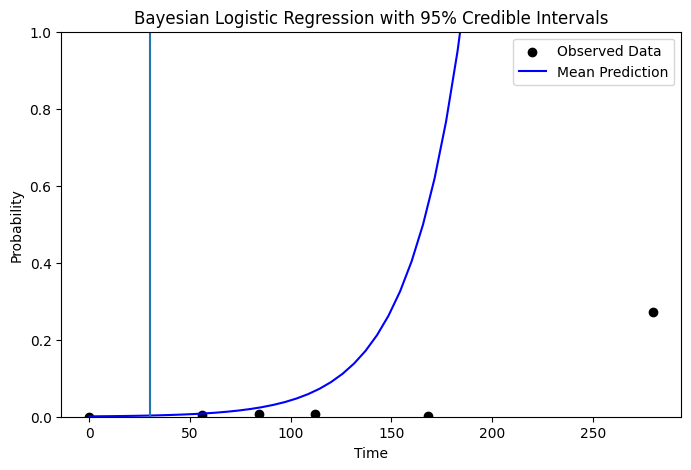

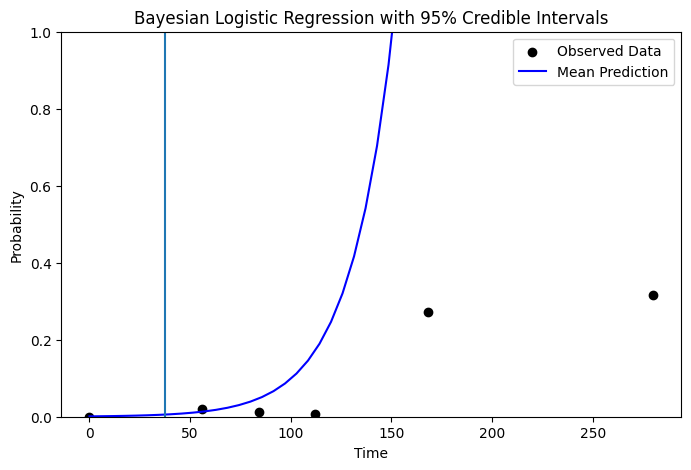

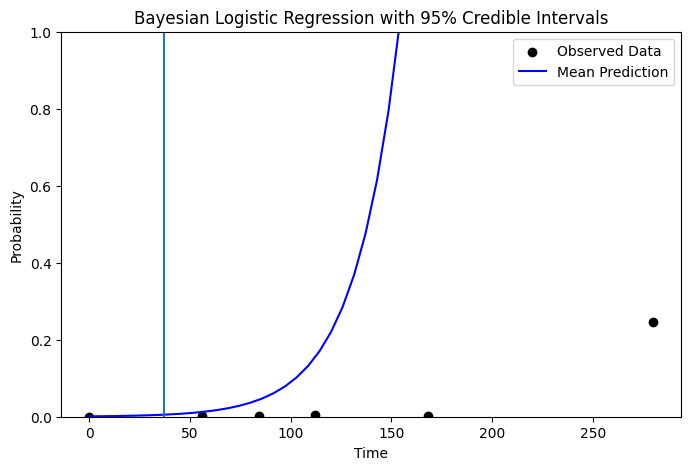

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Generate new x values (e.g., test points for prediction)
x_test = torch.linspace(0, torch.max(x), 50)

# post_fitness = posterior_samples_log["fitness"][:, None]

post_fitness = fitness.numpy() * (1 + obj.get_learned_params()["fitness"])
args = post_fitness * x_test.unsqueeze(1).numpy()
y_preds = np.exp(args)

init_time = obj.get_learned_params()["init_time"]

# Compute predictions for each posterior sample
y_mean = y_preds.mean(axis=0)  # Mean prediction
y_lower = np.quantile(y_preds, 0.025, axis=0)  # 2.5% quantile (
y_upper = np.quantile(y_preds, 0.975, axis=0)  # 97.5% quantile (upper bound)

# Plot results
for i in range(L):
    plt.figure(figsize=(8, 5))
    plt.scatter(x.squeeze(), y[:,i]/1000, color="black", label="Observed Data")  # Scatter plot of actual data
    # plt.scatter(x.squeeze(), y[:,i]/1000, color="black", label="Observed Data")  # Scatter plot of actual data
    plt.plot(x_test, y_preds[:,i]/1000, label="Mean Prediction", color="blue")
    # plt.plot(x_test, y_mean[:,i]/1000, label="Mean Prediction", color="blue")
    plt.vlines(x=init_time[i], ymin=0, ymax=1)
    # plt.fill_between(x_test, y_lower[:,i]/1000, y_upper[:,i]/1000, color="blue", alpha=0.3, label="95% Credible Interval")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Bayesian Logistic Regression with 95% Credible Intervals")
    plt.ylim([0,1])
    plt.show()

# Logistic

In [ ]:
import seaborn as sns
for k, v in posterior_samples_log.items():
    try:
        ax = sns.displot(v)
        ax.set(title=k)
    except:
        pass

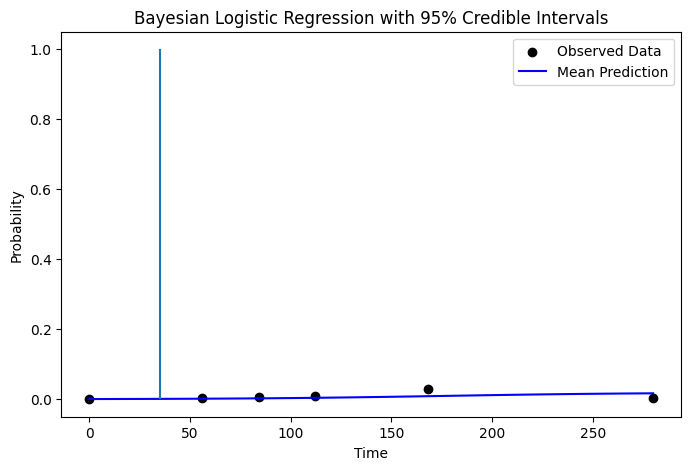

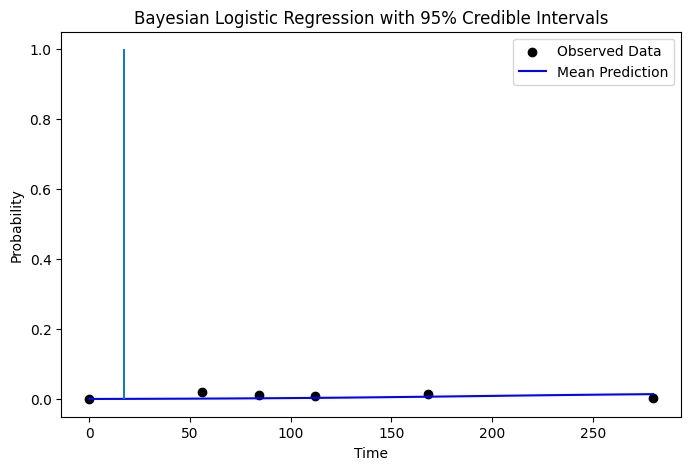

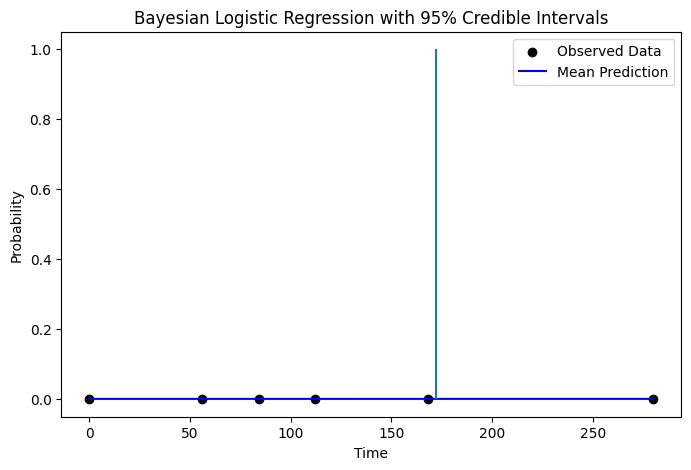

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# n_iters = posterior_samples_log["fitness"].shape[0]

# Generate new x values (e.g., test points for prediction)
x_test = torch.linspace(0, torch.max(x), 50)

if fitness is not None:
    post_fitness = fitness.numpy() * (1 + obj.get_learned_params()["fitness"])
else:
    post_fitness = obj.get_learned_params()["fitness"]
post_carr = obj.get_learned_params()["carr_capac"]
post_init_time = obj.get_learned_params()["init_time"]

args = - post_fitness * ( x_test.unsqueeze(1).numpy() - post_init_time )
y_preds = post_carr / ( 1 + (post_carr - 1) * np.exp(args) )
# Compute predictions for each posterior sample
y_lower = np.quantile(y_preds, 0.05, axis=0)  # 2.5% quantile (
y_upper = np.quantile(y_preds, 0.95, axis=0)  # 97.5% quantile (upper bound)

# Plot results
for i in range(L):
    plt.figure(figsize=(8, 5))
    plt.scatter(x.squeeze(), y[:,i]/1000, color="black", label="Observed Data")  # Scatter plot of actual data
    plt.plot(x_test, y_preds[:,i]/1000, label="Mean Prediction", color="blue")
    plt.vlines(x=post_init_time[i], ymin=0, ymax=1)
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Bayesian Logistic Regression with 95% Credible Intervals")
    plt.show()

In [164]:
obj._compute_log_ll()

array([-4.8043404, -6.8585773, -4.0680275], dtype=float32)

In [165]:
import pyro.distributions as distr
probs = torch.tensor([0.6018444, 0.7589351, 0.8302029, 0.9218317, 0.9999947])
logits = torch.log(probs / (1 - probs))
distr.Bernoulli(logits=logits).sample((10,))

tensor([[0., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])

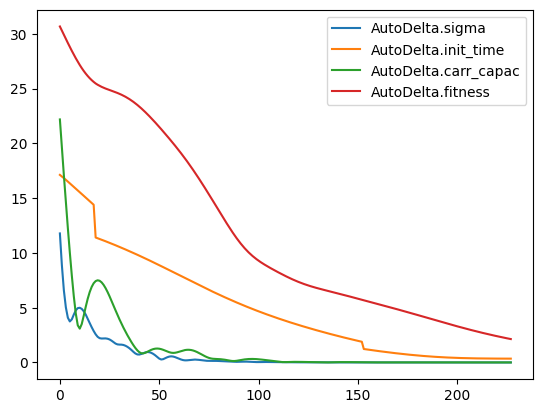

In [157]:
for k, v in obj.gradient_norms.items():
    plt.plot(v, label=k)
    plt.legend()

In [166]:
import numpy as np

def generate_samples(w, b, X_new, num_samples=1):
    """
    Generate new samples from a logistic regression model.
    
    Parameters:
        w (array-like): Coefficients of the logistic regression model.
        b (float): Intercept term.
        X_new (array-like): New input feature values.
        num_samples (int): Number of samples to generate per input.
    
    Returns:
        samples (array): Generated binary outcomes.
    """
    # Compute probability using the logistic (sigmoid) function
    logits = np.dot(X_new, w) + b
    probs = 1 / (1 + np.exp(-logits))  # Sigmoid function

    # Sample from a Bernoulli distribution
    samples = np.random.binomial(n=1, p=probs, size=(num_samples, len(X_new)))

    return samples

# Example usage
w = np.array([0.5, -0.3])  # Example coefficients
b = 0.2  # Example bias
X_new = np.array([[2.0, 1.0], [0.5, -0.5]])  # Example new inputs

generated_samples = generate_samples(w, b, X_new, num_samples=5)
print(generated_samples)


[[0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]
